# Analyze Training Results
Note:  You must run the previous notebook to generate debugger artifacts

In [1]:
!pip install -q --upgrade pip
!pip install -q wrapt --upgrade --ignore-installed
!pip install -q tensorflow==2.1.0

In [2]:
%store -r training_job_debugger_artifacts_path

In [3]:
print(training_job_debugger_artifacts_path)

s3://sagemaker-us-west-2-250107111215/tensorflow-training-2020-08-22-19-35-37-636/debug-output


## Analyze Tensors

Before getting to analysis, here are some notes on concepts being used in Debugger that help with analysis.
* **Trial** - object that is a center piece of Debugger API when it comes to getting access to tensors. It is a top level abstract that represents a single run of a training job. All tensors emitted by training job are associated with its trial.
* **Step** - object that represents next level of abstraction. In Debugger - step is a representation of a single batch of a training job. Each trial has multiple steps. Each tensor is associated with multiple steps - having a particular value at each of the steps.
* **Tensor** - object that represent actual tensor saved during training job. Note, a tensor can be a 1-D scaler, as well (ie. loss is stored as a scalar).

For more details on these concepts as well as on Debugger API in general (including examples) please refer to Debugger Analysis API documentation.

In [4]:
from smdebug.trials import create_trial

# this is where we create a Trial object that allows access to saved tensors
trial = create_trial(training_job_debugger_artifacts_path)

[2020-08-22 19:46:41.152 ip-172-16-24-238:12927 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-250107111215/tensorflow-training-2020-08-22-19-35-37-636/debug-output


In [5]:
for i in trial.tensor_names():
    print(i)

[2020-08-22 19:46:42.758 ip-172-16-24-238:12927 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-08-22 19:46:43.780 ip-172-16-24-238:12927 INFO trial.py:210] Loaded all steps
accuracy
batch
loss
size
val_accuracy
val_loss


In [6]:
import pandas as pd

def get_data(trial, tensor_name, batch_index, steps_range, mode):
    tensor = trial.tensor(tensor_name)
    vals = []
    for step_num in steps_range:
        val = tensor.value(step_num=step_num, mode=mode)[batch_index]
        vals.append(val)
    return pd.DataFrame(columns=['steps', tensor_name], data=list(zip(steps_range, vals)))

Waiting for tensors to become available...

Done
Getting tensors...
    steps  accuracy
0       0  0.265625
1      10  0.284801
2      20  0.291295
3      30  0.297631
4      40  0.305069
5      50  0.000000
6      60  0.000000
7      70  0.000000
8      80  0.000000
9      90  0.000000
10     99  0.313281
11    100  0.250000
12    110  0.250000
13    120  0.250000
14    130  0.250000
15    140  0.250000


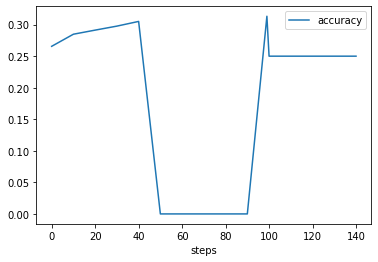

In [7]:
from smdebug.tensorflow import modes
import time

# Below we select the very first tensor from every batch.
# Feel free to modify this and select another tensor from the batch.
batch_index = 0

# This is a name of a tensor to analyze.
tensor_name = 'accuracy'

steps = 0
while steps == 0:
    # trial.steps return all steps that have been downloaded by Debugger to date.
    # It doesn't represent all steps that are to be available once training job is complete -
    # it is a snapshot of a current state of the training job. If you call it after training job is done
    # you will get all tensors available at once.
    steps = trial.steps()
    print('Waiting for tensors to become available...')
    time.sleep(3)
print('\nDone')

print('Getting tensors...')
rendered_steps = []

# trial.loaded_all_steps is a way to keep monitoring for a state of a training job as seen by Debugger.
# When SageMaker completes training job Debugger, and trial, becomes aware of it.

loaded_all_steps = False
while not loaded_all_steps:
    loaded_all_steps = trial.loaded_all_steps
    steps = trial.steps()
    # show diff between lists
    steps_to_render = sorted(list(set(steps).symmetric_difference(set(rendered_steps))))
    
    
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=0, 
                    steps_range=steps_to_render, 
                    mode=modes.GLOBAL)
    print(data)
    data.plot(x='steps', y=tensor_name)
    
    rendered_steps.extend(steps_to_render)
    time.sleep(5)

## Visualize Loss

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99, 100, 110, 120, 130, 140]
    steps      loss
0       0  1.594049
1      10  1.578797
2      20  1.569996
3      30  1.552882
4      40  1.547351
5      50  1.708658
6      60  1.708658
7      70  1.708658
8      80  1.708658
9      90  1.708658
10     99  1.561344
11    100  1.455803
12    110  1.455803
13    120  1.455803
14    130  1.455803
15    140  1.455803


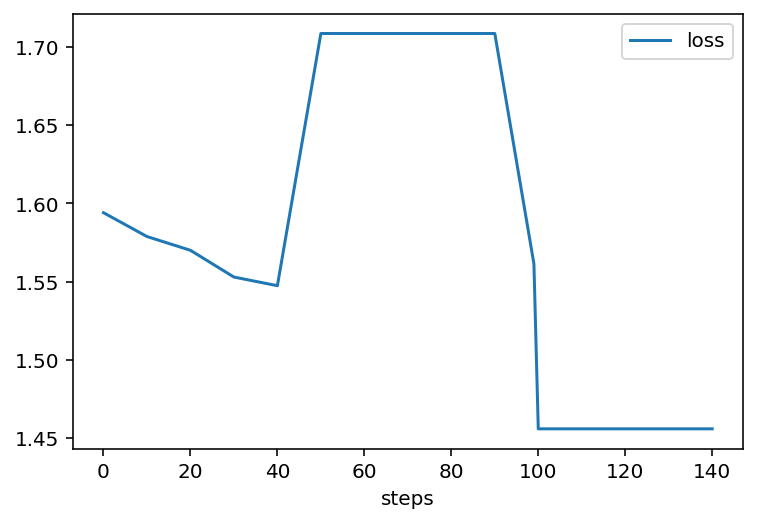

In [8]:
from smdebug.tensorflow import modes
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#from matplotlib import pyplot as plt

import pandas as pd

# Let's visualize weights of the first convolutional layer as they progressively change through training.
tensor_name = 'loss'

num_batches = trial.tensor(tensor_name).value(step_num=steps[0]).shape[0]
for batch_index in range(0, num_batches):
    steps_range = trial.tensor(tensor_name).steps()
    print(steps_range)
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=batch_index, 
                    steps_range=steps_range, 
                    mode=modes.GLOBAL)
    print(data)
    data.plot(x='steps', y=tensor_name)

## Visualize Accuracy

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99, 100, 110, 120, 130, 140]
    steps  accuracy
0       0  0.265625
1      10  0.284801
2      20  0.291295
3      30  0.297631
4      40  0.305069
5      50  0.000000
6      60  0.000000
7      70  0.000000
8      80  0.000000
9      90  0.000000
10     99  0.313281
11    100  0.250000
12    110  0.250000
13    120  0.250000
14    130  0.250000
15    140  0.250000


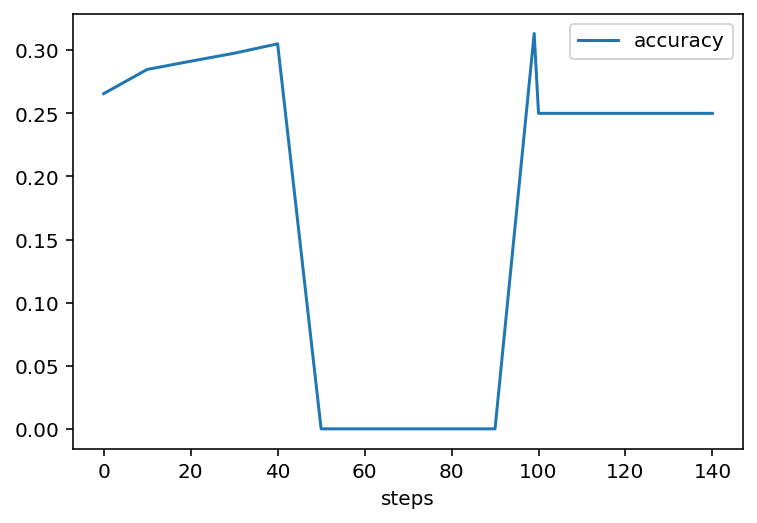

In [9]:
from smdebug.tensorflow import modes
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd

tensor_name = 'accuracy'

num_batches = trial.tensor(tensor_name).value(step_num=steps[0]).shape[0]
for batch_index in range(0, num_batches):
    steps_range = trial.tensor(tensor_name).steps()
    print(steps_range)
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=batch_index, 
                    steps_range=steps_range, 
                    mode=modes.GLOBAL)
    print(data)
    data.plot(x='steps', y=tensor_name)

In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();